In [1]:
import pandas as pd
import numpy as np
import nltk
import string
import regex
import re
import seaborn as sn
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from textblob import Word
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score,roc_curve,auc
from sklearn.multiclass import OneVsOneClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from tqdm import tqdm
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.preprocessing import LabelEncoder,LabelBinarizer
from sklearn.metrics import classification_report
plt.style.use('ggplot')
%matplotlib notebook

## Chargement des données et néttoyage:

In [2]:
def fonction_nettoyage_text(df):
    # supprission des ponctuations
    rm_ponct = str.maketrans('','',string.punctuation)
    df = df.apply(lambda x:x.translate(rm_ponct))
    # suppression les unicodes
    df = df.apply(lambda x:x.encode("ascii","ignore").decode("utf-8"))
                                                
    # suppression des URLs
    df = df.apply(lambda x:re.sub(r'http\S+',"",x))
    
    # suppression des stopwords
    stop_en = stopwords.words("english")
    df = df.apply(lambda x:" ".join(x.lower() for x in np.str(x).split() if x.lower() not in stop_en))
                                                  # Lemmatisation
    df = df.apply(lambda x:" ".join([Word(word).lemmatize() for word in x.split()]))
                  
    return(df)

## Split train-test validation:

In [3]:
dataset = pd.read_csv("data_set_version_final.csv")
dataset.resume=fonction_nettoyage_text(dataset.resume)

In [4]:
X_train,X_test,Y_train,y_test = train_test_split(dataset.resume,dataset.Labels,test_size=0.3,shuffle=True)
x_train,x_val,y_train,y_val = train_test_split(X_train,Y_train,test_size=0.3,shuffle=True)

## Skip-gram:

L'idée dans cette partie est d'utiliser les métriques qui se trouvent dans la construction de la méthode word2vec pour réaliser des prédictions. 



<img src="image_file/word_embeding.png" width="400">


Pour cela, on a déjà une classe qui a été codé pour simplifier les taches. Utilisons cette classe pour transformer notre text: 

In [5]:
from Word2VecTransformer import Embedding_Word2Vec

In [6]:
word2vecmodel=Embedding_Word2Vec(n_size=150,n_window=10,n_min_count=5,n_workers=4)

Par défaut, ce que l'on fait dans cette méthode c'est que l'on fait la moyenne des vecteurs de mot pour chaque documents. 
## Explication des différentes paramètres:

- **n_size** ici corréspond à la taille de la couche caché qui va nous servir  comme étant le vecteur qui représente un mot.
- **n_window** est la distance maximale entre le mot actuel et les mots qui lui corréspondent.
- **n_workers** est le nombre de processeur que l'on souaite utiliser.
- **n_min_count** on ignore les mots dont la fréquence est inféireur à cette paramètre.
- **n_sg** nous permet de choisir entre skip-gram et cbow (par défaut skip-gram)
- **n_sh** nous permet de choisir entre la fonction de soft max et le négatif simpling lorsque l'on va faire une déscente de gradien pour la partie optimisation.(valeur par défaut soft max)

On peut encore ajouter d'autre paramètres mais ces paramètres ci-dessus nous suffit. 

## Entrainement du modèle et transformation:

In [7]:
word2vecmodel.fit(x_train)

In [8]:
X_embeded_train_w2v=word2vecmodel.transform(x_train)
X_embeded_val_w2v=word2vecmodel.transform(x_val)
X_embeded_test_w2v=word2vecmodel.transform(X_test)

/home/tantely/anaconda3/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):
/home/tantely/anaconda3/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):
/home/tantely/anaconda3/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


Utilisons maintenant les différentes algorithmes de classifications sur ces plongements de mots que l'on a réalisé.

## SVM:

/home/tantely/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/tantely/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/tantely/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/tantely/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/tantely/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number o


 C optimal = 3.7275937203149416


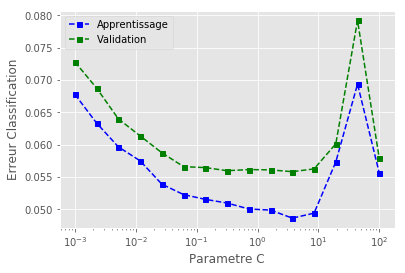

In [9]:
vectC = np.logspace(-3, 2, 15)
err_val = np.empty(vectC.shape[0])
err_app = np.empty(vectC.shape[0])
clf_svm=LinearSVC(C=1)

for ind_C, C in enumerate(vectC):
    clf_svm.C = C
    clf_svm.fit(X_embeded_train_w2v, y_train)
    # calcule erreur sur les donnees de validation et app
    err_val[ind_C] = 1 - accuracy_score(y_val, clf_svm.predict(X_embeded_val_w2v))
    err_app[ind_C] = 1 - accuracy_score(y_train, clf_svm.predict(X_embeded_train_w2v))
err_min_val, ind_min = err_val.min(), err_val.argmin()
Copt = vectC[ind_min]
print("\n C optimal = {}".format(Copt))
# Trace courbe erreur
plt.figure()
plt.semilogx(vectC, err_app, color="blue", linestyle="--", marker="s", markersize=5, label="Apprentissage")
plt.semilogx(vectC, err_val, color="green", linestyle="--", marker="s", markersize=5, label="Validation")
plt.xlabel("Parametre C")
plt.ylabel("Erreur Classification")
plt.legend(loc="best")
plt.show()

## Qualité du modèle:

In [10]:
from sklearn.metrics import recall_score,average_precision_score,f1_score
from sklearn.calibration import CalibratedClassifierCV

In [11]:
clf_svm.C = Copt
clf_svm_prob=CalibratedClassifierCV(clf_svm,cv=5)
clf_svm_prob.fit(X_embeded_train_w2v, y_train)
prediction_proba=clf_svm_prob.predict_proba(X_embeded_test_w2v)

/home/tantely/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/tantely/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/tantely/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/tantely/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/tantely/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number o

In [12]:
prediction=clf_svm.predict(X_embeded_test_w2v)

In [13]:
print("recall:{}".format(recall_score(y_test, prediction,average='weighted')))
print("accuracy:{}".format(accuracy_score(y_test,prediction)))
print("F1-score:{}".format(f1_score(y_test, prediction,average='weighted')))
#average_precision_score(y_test, prediction_proba)

recall:0.9459545158278577
accuracy:0.9459545158278577
F1-score:0.9460029184081234


In [14]:
print(classification_report(y_test, prediction))

                   precision    recall  f1-score   support

Finance_actuariat       1.00      0.99      1.00      1495
       chirurgien       0.93      0.93      0.93      8051
     cryptography       0.94      0.97      0.96      3161
   data scientist       0.94      0.95      0.94      3470
          dentist       0.97      0.92      0.95      8277
        developer       0.92      0.96      0.94      2188
ditital_marketing       0.97      0.99      0.98      3684
 network_engineer       0.98      0.97      0.98      3735
            nurse       0.90      0.95      0.93     10782
       pharmacist       0.98      0.91      0.94      6260
          robotic       0.96      0.95      0.96      5664

        micro avg       0.95      0.95      0.95     56767
        macro avg       0.95      0.95      0.95     56767
     weighted avg       0.95      0.95      0.95     56767



## Regression logistique:

In [15]:
pipline_RL=Pipeline([('skip_gram',Embedding_Word2Vec(n_size=150,n_window=10,n_min_count=5,n_workers=4)),('RL',LogisticRegression())])
pipline_RL.set_params(RL__C=1)

Pipeline(memory=None,
     steps=[('skip_gram', <Word2VecTransformer.Embedding_Word2Vec object at 0x7fa11fd2b9e8>), ('RL', LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))])

## Entrainement du modèle et inialisation du paramètre de la regression Linéaire:

In [16]:
rl=LogisticRegression()
rl.C=1
#rl.fit(X_embeded_train_w2v,y_train)
ter=pipline_RL.fit(x_train,y_train)
#pipline_RL.score(x_val,y_val)

/home/tantely/anaconda3/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):
/home/tantely/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/tantely/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [17]:
predictionRL=pipline_RL.predict(X_test)

/home/tantely/anaconda3/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [18]:
print("recall:{}".format(recall_score(y_test, predictionRL,average='weighted')))
print("accuracy:{}".format(accuracy_score(y_test,predictionRL)))
print("F1-score:{}".format(f1_score(y_test, predictionRL,average='weighted')))

recall:0.9463068331953424
accuracy:0.9463068331953424
F1-score:0.9464874684426319


In [19]:
print(classification_report(y_test, predictionRL))

                   precision    recall  f1-score   support

Finance_actuariat       0.99      0.98      0.98      1495
       chirurgien       0.95      0.91      0.93      8051
     cryptography       0.95      0.97      0.96      3161
   data scientist       0.94      0.95      0.94      3470
          dentist       0.97      0.93      0.95      8277
        developer       0.96      0.93      0.94      2188
ditital_marketing       0.98      0.99      0.98      3684
 network_engineer       0.98      0.97      0.98      3735
            nurse       0.88      0.97      0.92     10782
       pharmacist       0.98      0.90      0.94      6260
          robotic       0.96      0.96      0.96      5664

        micro avg       0.95      0.95      0.95     56767
        macro avg       0.96      0.95      0.95     56767
     weighted avg       0.95      0.95      0.95     56767



## Cross Validation sur le modèle logistique:

0it [00:00, ?it/s]/home/tantely/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/tantely/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
1it [02:03, 123.60s/it]/home/tantely/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/tantely/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
2it [04:02, 122.16s/it]/home/

17it [39:12, 143.93s/it]/home/tantely/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/tantely/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
18it [41:51, 148.62s/it]/home/tantely/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/tantely/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
19it [44:22, 149.34s/i


 C optimal = 5.5


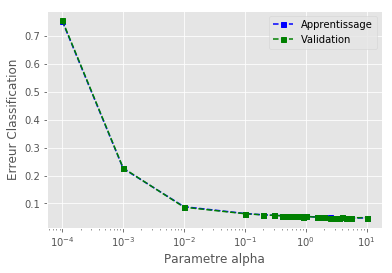

In [21]:
vectC = np.array([1e-4,1e-3,1e-2,1e-1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,1.5,1.6,2,2.5,3,3.5,4,4.5,5,5.5,10])
err_val = np.empty(vectC.shape[0])
err_app = np.empty(vectC.shape[0])
for ind_C, C in tqdm(enumerate(vectC)):
    pipline_RL.set_params(RL__C=C)
    temp=pipline_RL.fit(x_train, y_train)
    # calcule erreur sur les donnees de validation et app
    err_val[ind_C] = 1 - accuracy_score(y_val, pipline_RL.predict(x_val))
    err_app[ind_C] = 1 - accuracy_score(y_train, pipline_RL.predict(x_train))
err_min_val, ind_min = err_val.min(), err_val.argmin()
Copt = vectC[ind_min]
print("\n C optimal = {}".format(Copt))
# Trace courbe erreur
plt.figure()
plt.semilogx(vectC, err_app, color="blue", linestyle="--", marker="s", markersize=5, label="Apprentissage")
plt.semilogx(vectC, err_val, color="green", linestyle="--", marker="s", markersize=5, label="Validation")
plt.xlabel("Parametre alpha")
plt.ylabel("Erreur Classification")
plt.legend(loc="best")
plt.show()

In [22]:
pipline_RL.set_params(RL__C=Copt)
temp=pipline_RL.fit(x_train, y_train)
predRL=pipline_RL.predict(X_test)   
print("recall:{}".format(recall_score(y_test, predRL,average='weighted')))
print("accuracy:{}".format(accuracy_score(y_test,predRL)))
print("F1-score:{}".format(f1_score(y_test,predRL,average='weighted')))

/home/tantely/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/tantely/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


recall:0.9492134514770906
accuracy:0.9492134514770906
F1-score:0.9492541919905253


In [23]:
print(classification_report(y_test, prediction))

                   precision    recall  f1-score   support

Finance_actuariat       0.99      1.00      1.00      1522
       chirurgien       0.95      0.91      0.93      7955
     cryptography       0.98      0.96      0.97      3211
   data scientist       0.95      0.94      0.95      3426
          dentist       0.96      0.94      0.95      8149
        developer       0.96      0.94      0.95      2227
ditital_marketing       0.98      0.99      0.99      3666
 network_engineer       0.98      0.97      0.97      3716
            nurse       0.90      0.95      0.93     10857
       pharmacist       0.94      0.94      0.94      6379
          robotic       0.96      0.97      0.97      5659

        micro avg       0.95      0.95      0.95     56767
        macro avg       0.96      0.96      0.96     56767
     weighted avg       0.95      0.95      0.95     56767



## KNN:

In [28]:
pipline=Pipeline([('skip_gram',Embedding_Word2Vec(n_size=150,n_window=10,n_min_count=5,n_workers=4)),('knn',KNeighborsClassifier())])

  0%|          | 0/8 [00:00<?, ?it/s]/home/tantely/anaconda3/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):
/home/tantely/anaconda3/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):
/home/tantely/anaconda3/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):
 12%|█▎        | 1/8 [12:32<1:27:50, 752.93s/it]/home/tantely/anaconda3/lib/python3.

With all being CV, best k is 2 and best perf is 0.9772252560585852


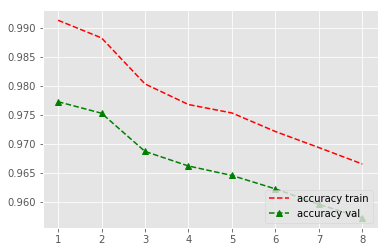

In [29]:
k_values = [2,3,5,6,7,8,9,10]
perf_train=[]
perf_val=[]
for k in tqdm(k_values):
    pipline.set_params(knn__n_neighbors=k)
    pipline.fit(x_train, y_train)
    y_pred_train = pipline.predict(x_train)
    y_pred_val=pipline.predict(x_val)
    scores_train = accuracy_score(y_train, y_pred_train)
    scores_val=accuracy_score(y_val,y_pred_val)
    perf_train.append(scores_train)
    perf_val.append(scores_val)
plt.figure()
plt.plot(range(1,len(perf_train)+1),perf_train,"--r",range(1,len(perf_val)+1),perf_val,"--g^")
plt.legend(['accuracy train', 'accuracy val'],loc="lower right")
print('With all being CV, best k is '    +repr(k_values[perf_val.index(max(perf_val))])+ ' and best perf is ' + repr(max(perf_val)))

Entre l'accuracy et le train,on a un décalage qui semble être constante pour tout valeur de k. Dons on peut dire que l'on ne suaprend pas.

In [30]:
pipline.set_params(knn__n_neighbors=k_values[perf_val.index(max(perf_val))])
pipline.fit(x_train, y_train)
pred_knn = pipline.predict(X_test)

/home/tantely/anaconda3/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):
/home/tantely/anaconda3/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [31]:
print("recall:{}".format(recall_score(y_test, pred_knn,average='weighted')))
print("accuracy:{}".format(accuracy_score(y_test,pred_knn)))
print("F1-score:{}".format(f1_score(y_test,pred_knn,average='weighted')))

recall:0.9772755297972413
accuracy:0.9772755297972413
F1-score:0.977275449841215


Dans ce cas ci, on remarque que le knn semble être meilleur comparé  à la regression logistique et la régression linéaire. 

### Utilisation du négative Simpling pour la déscente de gradien:
Nous allons refaire tout ce que l'on avait fait avant et prendre l'option **n_sh** comme étant égale à 0 pour l'utilisation du négatif simpling. 

## Remarque:
Comme l'utilisation du Pipeline prend plus de temps, nous 'allons plus utiliser les pipelines dans la suite.

In [32]:
word2vecmodel=Embedding_Word2Vec(n_size=150,n_window=10,n_min_count=5,n_workers=4,n_hs=0)
word2vecmodel.fit(x_train)
X_embeded_train_w2v=word2vecmodel.transform(x_train)
X_embeded_val_w2v=word2vecmodel.transform(x_val)
X_embeded_test_w2v=word2vecmodel.transform(X_test)

/home/tantely/anaconda3/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):
/home/tantely/anaconda3/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):
/home/tantely/anaconda3/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


8it [01:09, 13.19s/it]/home/tantely/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
9it [01:59, 24.20s/it]/home/tantely/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
10it [03:14, 39.50s/it]/home/tantely/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
11it [04:53, 57.44s/it]/home/tantely/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
12it [07:03, 79.23s/it]/home/tantely/anaconda3/lib/python3


 C optimal = 3.7275937203149416


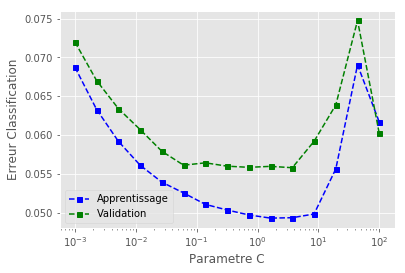

In [33]:
vectC = np.logspace(-3, 2, 15)
err_val = np.empty(vectC.shape[0])
err_app = np.empty(vectC.shape[0])
clf_svm=LinearSVC(C=1)

for ind_C, C in tqdm(enumerate(vectC)):
    clf_svm.C = C
    clf_svm.fit(X_embeded_train_w2v, y_train)
    # calcule erreur sur les donnees de validation et app
    err_val[ind_C] = 1 - accuracy_score(y_val, clf_svm.predict(X_embeded_val_w2v))
    err_app[ind_C] = 1 - accuracy_score(y_train, clf_svm.predict(X_embeded_train_w2v))
err_min_val, ind_min = err_val.min(), err_val.argmin()
Copt = vectC[ind_min]
print("\n C optimal = {}".format(Copt))
# Trace courbe erreur
plt.figure()
plt.semilogx(vectC, err_app, color="blue", linestyle="--", marker="s", markersize=5, label="Apprentissage")
plt.semilogx(vectC, err_val, color="green", linestyle="--", marker="s", markersize=5, label="Validation")
plt.xlabel("Parametre C")
plt.ylabel("Erreur Classification")
plt.legend(loc="best")
plt.show()

In [34]:
clf_svm.C = Copt
clf_svm_prob=CalibratedClassifierCV(clf_svm,cv=5)
clf_svm_prob.fit(X_embeded_train_w2v, y_train)
prediction_proba=clf_svm_prob.predict_proba(X_embeded_test_w2v)

/home/tantely/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/tantely/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/tantely/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/tantely/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/tantely/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number o

In [35]:
prediction=clf_svm.predict(X_embeded_test_w2v)
print("recall:{}".format(recall_score(y_test, prediction,average='weighted')))
print("accuracy:{}".format(accuracy_score(y_test,prediction)))
print("F1-score:{}".format(f1_score(y_test, prediction,average='weighted')))

recall:0.9354554582768158
accuracy:0.9354554582768158
F1-score:0.9357882917459645


In [36]:
print(classification_report(y_test, prediction))

                   precision    recall  f1-score   support

Finance_actuariat       0.99      1.00      1.00      1495
       chirurgien       0.90      0.93      0.92      8051
     cryptography       0.84      0.99      0.91      3161
   data scientist       0.92      0.95      0.93      3470
          dentist       0.99      0.88      0.93      8277
        developer       0.99      0.85      0.92      2188
ditital_marketing       1.00      0.98      0.99      3684
 network_engineer       0.99      0.97      0.98      3735
            nurse       0.88      0.95      0.92     10782
       pharmacist       0.96      0.92      0.94      6260
          robotic       0.97      0.94      0.95      5664

        micro avg       0.94      0.94      0.94     56767
        macro avg       0.95      0.94      0.94     56767
     weighted avg       0.94      0.94      0.94     56767



A partir de la 4 eme décimale on remarque que l'on est moins meilleurs que lorsqu'on utilise la fonction soft max.

## Regression logistique:

In [37]:
rl=LogisticRegression(multi_class="auto",solver="lbfgs")

1it [00:04,  4.58s/it]/home/tantely/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
2it [00:10,  4.95s/it]/home/tantely/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
3it [00:15,  5.13s/it]/home/tantely/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
4it [00:21,  5.31s/it]/home/tantely/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
5it [00:27,  5.44s/it]/home/tantely/anaconda3/lib/python3.6/site-pac


 C optimal = 10.0


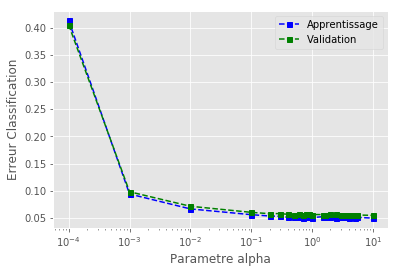

In [38]:
vectC = np.array([1e-4,1e-3,1e-2,1e-1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,1.5,1.6,2,2.5,3,3.5,4,4.5,5,5.5,10])
err_val = np.empty(vectC.shape[0])
err_app = np.empty(vectC.shape[0])
for ind_C, C in tqdm(enumerate(vectC)):
    rl.C=C
    temp=rl.fit(X_embeded_train_w2v, y_train)
    # calcule erreur sur les donnees de validation et app
    err_val[ind_C] = 1 - accuracy_score(y_val, rl.predict(X_embeded_val_w2v))
    err_app[ind_C] = 1 - accuracy_score(y_train, rl.predict(X_embeded_train_w2v))
err_min_val, ind_min = err_val.min(), err_val.argmin()
Copt = vectC[ind_min]
print("\n C optimal = {}".format(Copt))
# Trace courbe erreur
plt.figure()
plt.semilogx(vectC, err_app, color="blue", linestyle="--", marker="s", markersize=5, label="Apprentissage")
plt.semilogx(vectC, err_val, color="green", linestyle="--", marker="s", markersize=5, label="Validation")
plt.xlabel("Parametre alpha")
plt.ylabel("Erreur Classification")
plt.legend(loc="best")
plt.show()

In [39]:
rl.C=Copt
temp=rl.fit(X_embeded_train_w2v, y_train)
predRL=rl.predict(X_embeded_test_w2v)   
print("recall:{}".format(recall_score(y_test, predRL,average='weighted')))
print("accuracy:{}".format(accuracy_score(y_test,predRL)))
print("F1-score:{}".format(f1_score(y_test,predRL,average='weighted')))

/home/tantely/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


recall:0.9502175559744218
accuracy:0.9502175559744218
F1-score:0.9502678813854412


In [40]:
print(classification_report(y_test, predRL))

                   precision    recall  f1-score   support

Finance_actuariat       0.99      0.97      0.98      1495
       chirurgien       0.95      0.92      0.94      8051
     cryptography       0.95      0.96      0.96      3161
   data scientist       0.93      0.95      0.94      3470
          dentist       0.96      0.96      0.96      8277
        developer       0.95      0.93      0.94      2188
ditital_marketing       0.99      0.99      0.99      3684
 network_engineer       0.97      0.97      0.97      3735
            nurse       0.91      0.95      0.93     10782
       pharmacist       0.95      0.93      0.94      6260
          robotic       0.97      0.96      0.96      5664

        micro avg       0.95      0.95      0.95     56767
        macro avg       0.96      0.95      0.96     56767
     weighted avg       0.95      0.95      0.95     56767



On a des valeurs un peu plus optimal lorsque l'on utilise le negatif simpling à la place de la fonction soft max.

## KNN:

In [41]:
knn=KNeighborsClassifier()

100%|██████████| 8/8 [3:41:50<00:00, 1932.23s/it]  

With all being CV, best k is 2 and best perf is 0.9773510833731787


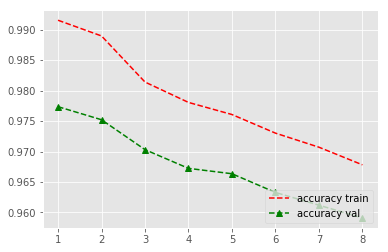

In [42]:
k_values = [2,3,5,6,7,8,9,10]
perf_train=[]
perf_val=[]
for k in tqdm(k_values):
    knn.n_neighbors=k
    knn.fit(X_embeded_train_w2v, y_train)
    y_pred_train = knn.predict(X_embeded_train_w2v)
    y_pred_val=knn.predict(X_embeded_val_w2v)
    scores_train = accuracy_score(y_train, y_pred_train)
    scores_val=accuracy_score(y_val,y_pred_val)
    perf_train.append(scores_train)
    perf_val.append(scores_val)
plt.figure()
plt.plot(range(1,len(perf_train)+1),perf_train,"--r",range(1,len(perf_val)+1),perf_val,"--g^")
plt.legend(['accuracy train', 'accuracy val'],loc="lower right")
print('With all being CV, best k is '    +repr(k_values[perf_val.index(max(perf_val))])+ ' and best perf is ' + repr(max(perf_val)))

In [43]:
knn.n_neighbors=k_values[perf_val.index(max(perf_val))]
knn.fit(X_embeded_train_w2v, y_train)
pred_knn = knn.predict(X_embeded_test_w2v)

In [44]:
print("recall:{}".format(recall_score(y_test, pred_knn,average='weighted')))
print("accuracy:{}".format(accuracy_score(y_test,pred_knn)))
print("F1-score:{}".format(f1_score(y_test,pred_knn,average='weighted')))

recall:0.9781739390843271
accuracy:0.9781739390843271
F1-score:0.978170889479705


In [45]:
print(classification_report(y_test, pred_knn))

                   precision    recall  f1-score   support

Finance_actuariat       0.99      1.00      0.99      1495
       chirurgien       0.96      0.98      0.97      8051
     cryptography       0.99      0.99      0.99      3161
   data scientist       0.97      0.99      0.98      3470
          dentist       0.97      0.99      0.98      8277
        developer       0.98      0.96      0.97      2188
ditital_marketing       1.00      1.00      1.00      3684
 network_engineer       0.98      0.99      0.99      3735
            nurse       0.97      0.96      0.97     10782
       pharmacist       0.99      0.96      0.98      6260
          robotic       1.00      0.98      0.99      5664

        micro avg       0.98      0.98      0.98     56767
        macro avg       0.98      0.98      0.98     56767
     weighted avg       0.98      0.98      0.98     56767



## Naîve Baysian:

In [20]:
modelNB=MultinomialNB()

24it [00:10,  2.40it/s]



 C optimal = 10.0


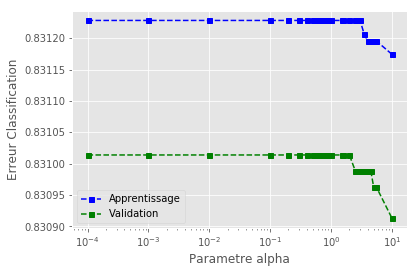

In [24]:
vectC = np.array([1e-4,1e-3,1e-2,1e-1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,1.5,1.6,2,2.5,3,3.5,4,4.5,5,5.5,10])
err_val = np.empty(vectC.shape[0])
err_app = np.empty(vectC.shape[0])
for ind_C, C in tqdm(enumerate(vectC)):
    modelNB.set_params(alpha=C)
    modelNB.fit(X_embeded_train_w2v, y_train)
    # calcule erreur sur les donnees de validation et app
    err_val[ind_C] = accuracy_score(y_val, modelNB.predict(X_embeded_val_w2v))
    err_app[ind_C] =accuracy_score(y_train, modelNB.predict(X_embeded_train_w2v))
err_min_val, ind_min = err_val.min(), err_val.argmin()
Copt = vectC[ind_min]
print("\n C optimal = {}".format(Copt))
# Trace courbe erreur
plt.figure()
plt.semilogx(vectC, err_app, color="blue", linestyle="--", marker="s", markersize=5, label="Apprentissage")
plt.semilogx(vectC, err_val, color="green", linestyle="--", marker="s", markersize=5, label="Validation")
plt.xlabel("Parametre alpha")
plt.ylabel("accuracy Classification")
plt.legend(loc="best")
plt.show()

In [25]:
modelNB.set_params(alpha=Copt)
modelNB.fit(X_embeded_train_w2v, y_train)
pred=modelNB.predict(X_embeded_test_w2v)

In [26]:
print(classification_report(y_test, pred))

                   precision    recall  f1-score   support

Finance_actuariat       0.99      0.59      0.74      1495
       chirurgien       0.91      0.78      0.84      8051
     cryptography       0.98      0.70      0.81      3161
   data scientist       0.90      0.86      0.88      3470
          dentist       0.88      0.85      0.86      8277
        developer       0.99      0.66      0.79      2188
ditital_marketing       0.99      0.95      0.97      3684
 network_engineer       0.98      0.87      0.92      3735
            nurse       0.66      0.96      0.78     10782
       pharmacist       0.99      0.61      0.75      6260
          robotic       0.73      0.95      0.83      5664

        micro avg       0.83      0.83      0.83     56767
        macro avg       0.91      0.80      0.83     56767
     weighted avg       0.87      0.83      0.83     56767



In [27]:
print("recall:{}".format(recall_score(y_test, pred,average='weighted')))
print("accuracy:{}".format(accuracy_score(y_test,pred)))
print("F1-score:{}".format(f1_score(y_test,pred,average='weighted')))

recall:0.8311342857646168
accuracy:0.8311342857646168
F1-score:0.8317000690508695
